In [117]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import re
from sklearn.preprocessing import OneHotEncoder
import spacy
import matplotlib.pyplot as plt



In [114]:
# Load csv file into dataframe
data = pd.read_csv("/content/GlassDoor_1000_Companies.csv")

# Replace 'k' with '000' in Reviews and Salaries columns
data['Reviews'] = data['Reviews'].str.replace('K', '000')
data['Salaries'] = data['Salaries'].str.replace('K', '000')

# Extract only the number from the Location column if plural, otherwise assume 1 location if single address
for i, row in enumerate(data['Location']):
    if 'office' in row:
        num = re.findall(r'\d+', row)[0]
        data.at[i, 'Location'] = num
    else:
        data.at[i, 'Location'] = 1

# Extract only the number from the Company_Size column if plural, otherwise assume lowest employee size
for i, row in enumerate(data['Company_Size']):
    if '+' in row:
        num = re.findall(r'\d+', row)[0]
        data.at[i, 'Company_Size'] = num
    elif 'to' in row:
        num = re.findall(r'\d+', row)[0]
        data.at[i, 'Company_Size'] = num
    else:
        # if the value is 'Unknown', drop the row
        data.drop(i, inplace=True)

#standardize industry names 
def standardize_industry(industry_name):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(industry_name)
    standardized_industry = ''
    for token in doc:
        if not token.is_stop and not token.is_punct:
            standardized_industry += token.lemma_ + ' '
    return standardized_industry.strip()

# Convert the Salaries, Reviews, and Locations columns to numeric format
data['Salaries'] = pd.to_numeric(data['Salaries'])
data['Reviews'] = pd.to_numeric(data['Reviews'])
data['Location'] = pd.to_numeric(data['Location'])
data['Company_Size'] = pd.to_numeric(data['Company_Size'])

# Drop rows with missing or NaN values
data.dropna(inplace=True)

# Prepare training features, remove target and Location columns
X = data.drop(['Salaries', 'Jobs', 'Company'], axis=1)

# Load target column
y = data['Salaries']

# Partition into training and testing blocks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train['Industry'] = X_train['Industry'].apply(standardize_industry)

#keep top 5 industries for simplicity
top_5_industries = X_train['Industry'].value_counts().nlargest(5).index
X_train.loc[~X_train['Industry'].isin(top_5_industries), 'Industry'] = 'Other'

# Convert 'Industry' column to categorical data type
X_train['Industry'] = X_train['Industry'].astype('category')

# Perform one hot encoding on 'Industry' column
X_train = pd.concat([X_train.drop('Industry', axis=1), pd.get_dummies(X_train['Industry'], prefix='Industry')], axis=1)

# Apply industry standardization to test variables
X_test['Industry'] = X_test['Industry'].apply(standardize_industry)
X_test.loc[~X_test['Industry'].isin(top_5_industries), 'Industry'] = 'Other'

# Convert 'Industry' column to categorical data type
X_test['Industry'] = X_test['Industry'].astype('category')

# Perform one hot encoding on 'Industry' column
X_test = pd.concat([X_test.drop('Industry', axis=1), pd.get_dummies(X_test['Industry'], prefix='Industry')], axis=1)


In [115]:
# Build the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# Define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)



Epoch 1/100
20/20 [==============================] - 1s 11ms/step - loss: 1665.8267 - val_loss: 1007.5953
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1254.6254 - val_loss: 500.0796
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 1136.3201 - val_loss: 515.3343
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 1059.9000 - val_loss: 522.3633
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 975.0521 - val_loss: 570.2632
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 891.1641 - val_loss: 482.9656
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 877.6269 - val_loss: 484.1821
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 835.5978 - val_loss: 449.7128
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 818.2702 - val_loss: 443.6830
Epoch 10/100
20/20 [==============================] - 0s 4ms/step -

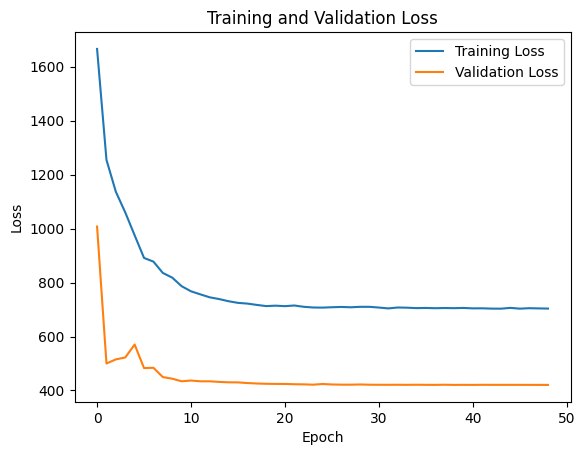

In [116]:
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
